[INFO] loading images...
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 91s 3s/step - loss: 0.4337 - accuracy: 0.8024 - val_loss: 0.1051 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 77s 2s/step - loss: 0.1140 - accuracy: 0.9672 - val_loss: 0.0524 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 88s 3s/step - loss: 0.0770 - accuracy: 0.9775 - val_loss: 0.0379 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 84s 2s/step - loss: 0.0529 - accuracy: 0.9860 - val_loss: 0.0322 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 74s 2s/step - loss: 0.0439 - accuracy: 0.9860 - val_loss: 0.0217 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 80s 2s/step - loss: 0.0291 - accuracy: 0.9934 - val_loss: 0.0205 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 78s 2s/step - loss: 0.0258 - accu

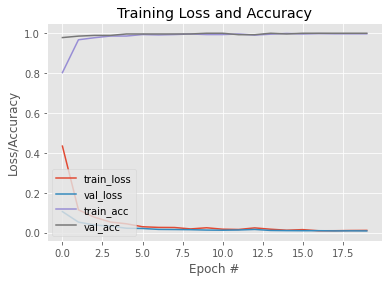

In [3]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"./dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

# complete folder of dataset is enter into data and labels(it has category) list
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
# As category having 2 fields with mask, without mask we need to convert them into number(0 and 1) so called LabelBinarizer()
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# converting both data and labels list to array
data = np.array(data, dtype="float32")
labels = np.array(labels)

# splitting into train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
# imagenet is pretrained model specifically for images... as we are using images those predefined weights will be initialize for us 
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3))) # i.e 224x224 size and 3 stands for RGB

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)  # relu is basically goto activation function for non-linear cases...(as images use relu)
headModel = Dropout(0.5)(headModel)  # dropout to avoid overfitting
headModel = Dense(2, activation="softmax")(headModel) # softmax because there probabilty values based on 0 and 1
# dense 2 because 1 is for with mask and other without mask

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


In [5]:
import tensorflow as tf
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [6]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

9523708

In [7]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

NameError: name 'convert_bytes' is not defined